In this notebook, we use the FoldX feature set (13 features) to predict soluble expression (0=no, 1=yes) for 128 samples. Three classifiers are tried: logistic regression, SVM, and random forest 

In [127]:
%matplotlib inline 
import matplotlib.pyplot as plt 

import pandas 
from pandas.tools.plotting import scatter_matrix

from sklearn import preprocessing, cross_validation, ensemble, pipeline, svm, decomposition
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.linear_model import LogisticRegressionCV

In [128]:
df = pandas.read_csv( 'feature_sets/expression_foldx.csv', index_col=0 ) 

In [129]:
df.columns

Index([u'total energy', u'Backbone Hbond', u'Sidechain Hbond',
       u'Van der Waals', u'Electrostatics', u'Solvation Polar',
       u'Solvation Hydrophobic', u'Van der Waals clashes',
       u'entropy sidechain', u'entropy mainchain', u'torsional clash',
       u'backbone clash', u'helix dipole', u'electrostatic kon',
       u'energy Ionisation', u'expression'],
      dtype='object')

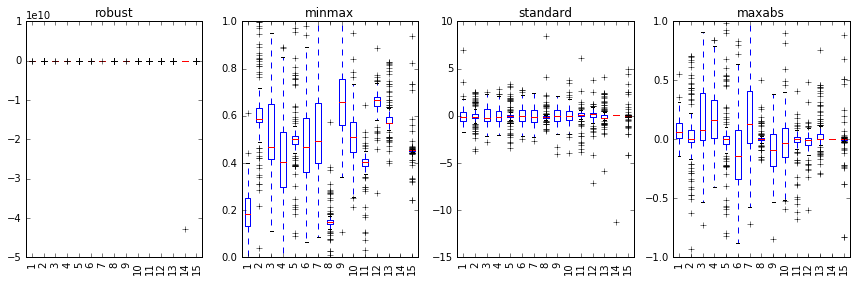

In [130]:
# investigate different scaling methods 

scalers = [ 
    ( 'robust', preprocessing.RobustScaler() ), 
    ( 'minmax', preprocessing.MinMaxScaler() ), 
    ( 'standard', preprocessing.StandardScaler() ), 
    ( 'maxabs', preprocessing.MaxAbsScaler() ), 
]

plt.figure( figsize=(12, 4) )
for i, ( scaler_name, scaler ) in enumerate( scalers ):
    plt.subplot( 1, len( scalers ), i + 1 )
    plt.title( scaler_name ) 
    plt.boxplot( scaler.fit_transform( df.ix[:,:-1] ) )
    plt.xticks( rotation=90 ) 
plt.tight_layout()    

In [131]:
# scale features and separate into predictors

scl = preprocessing.MaxAbsScaler()
X = scl.fit_transform( df.ix[:,:-1] )
y = df.ix[:,-1].ravel()

print X.shape
print y.shape

(128, 15)
(128,)


In [132]:
# # %matplotlib inline 
# # import matplotlib.pyplot as plt 

# plt.figure( figsize=( 14, 14 ) ) 

# for i, feature in enumerate( df.columns ):
#     plt.subplot( 4, 4, i + 1 ) 
#     plt.scatter( df.expression, df[ feature ], c='k', alpha=0.1 ) #, c=df.expression, cmap='Blues', vmin=-0.5 ) 
#     plt.title( feature ) 
#     plt.xticks( [ 0, 1 ], [ 0, 1 ] ) 

# plt.show()

**FoldX feature set**: individual feature versus expression (yes/no)

In [133]:
#scatter_matrix(df, alpha=0.2, figsize=(14, 14) ) #, diagonal='kde')

In [134]:
# sequence-based view of features 
#df.plot(subplots=True, style='.', figsize=(14,14))

In [135]:
df.corr(method='spearman')['expression'].drop( 'expression' ).sort_values()

total energy            -0.416102
Solvation Polar         -0.189585
entropy sidechain       -0.166086
Van der Waals clashes   -0.161382
energy Ionisation       -0.114983
helix dipole            -0.068879
torsional clash         -0.035589
electrostatic kon       -0.033061
backbone clash          -0.032456
Solvation Hydrophobic   -0.029770
entropy mainchain       -0.002462
Van der Waals            0.015892
Backbone Hbond           0.029102
Electrostatics           0.122887
Sidechain Hbond          0.190301
Name: expression, dtype: float64

In [136]:
# unbalanced classes 
my_list = list( y ) 
print my_list.count( 0 ), 'samples of class 0'
print my_list.count( 1 ), 'samples of class 1'

43 samples of class 0
85 samples of class 1


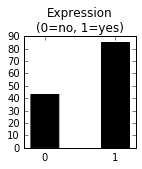

In [137]:
plt.figure( figsize=( 2,2 ) ) 
plt.hist( y, bins=2, color='k', rwidth=0.4 )
plt.xticks( [ .25, .75 ], [ '0', '1' ] ) 
plt.title( 'Expression\n(0=no, 1=yes)' ) 

In [138]:
# Split the dataset in two equal parts to be used to train and test 3 classifiers below 
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.5)

[[ 8 15]
 [ 3 38]]
             precision    recall  f1-score   support

          0       0.73      0.35      0.47        23
          1       0.72      0.93      0.81        41

avg / total       0.72      0.72      0.69        64



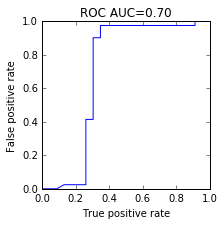

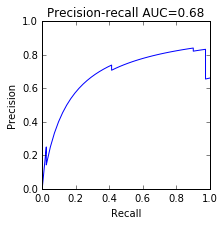

In [139]:
# random forest

from sklearn.naive_bayes import GaussianNB

param_grid = [{}]
  
pln = pipeline.Pipeline([
    ( 'nb', GaussianNB() ),
])

# fit the model 
clf = GridSearchCV( pln, param_grid, cv=10 )
clf.fit( X_train, y_train )

# predict class labels in test set 
y_true, y_pred = y_test, clf.predict(X_test)

# print("Best parameters found on training set")
# print(clf.best_params_)

# print("Grid scores on training set")
# for params, mean_score, scores in clf.grid_scores_:
#     print("%0.3f (±%0.03f) for %r" % (mean_score, scores.std() * 2, params))

#print("Detailed classification report")

print confusion_matrix( y_true, y_pred )
print classification_report( y_true, y_pred )

y_desc = clf.predict_proba( X_test )
y_prob = [ i[j] for i, j in zip( y_desc, y_true ) ] # the probability for the given class label

# ROC curve 
tpr, fpr, __ = roc_curve( y_true, y_prob ) 
my_auc = roc_auc_score( y_true, y_prob ) 
plt.figure( figsize=( 3,3 ) ) 
plt.plot( tpr, fpr ) 
plt.xlabel( 'True positive rate' )
plt.ylabel( 'False positive rate' )
plt.title( 'ROC AUC={0:.2f}'.format( my_auc ) ) 
plt.show()

# Precision-recall curve 
precision, recall, __ = precision_recall_curve( y_true, y_prob ) 
my_auc = average_precision_score( y_true, y_prob ) 
plt.figure( figsize=( 3,3 ) ) 
plt.plot( recall, precision ) 
plt.xlabel( 'Recall' )
plt.ylabel( 'Precision' )
plt.title( 'Precision-recall AUC={0:.2f}'.format( my_auc ) ) 
plt.show()

# Feature importance 
# feat_import = clf.best_estimator_.named_steps['rf'].feature_importances_
# w = pandas.DataFrame( zip( df.columns[:-1], feat_import ), columns=['feature','importance'] )
# w.set_index( 'feature', inplace=True ) 
# w.sort_values( by='importance', ascending=False )

In [145]:
from sklearn.naive_bayes import GaussianNB

param_grid = [{}]
  
pln = pipeline.Pipeline([
    ( 'nb', GaussianNB() ),
])

# fit the model 
clf = GridSearchCV( pln, param_grid, cv=10 )
clf.fit( X, y )
preds = clf.predict( X )
prob = clf.predict_proba( X ) 

print preds

print confusion_matrix( y, preds )
print classification_report( y, preds ) 

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[[43  0]
 [83  2]]
             precision    recall  f1-score   support

          0       0.34      1.00      0.51        43
          1       1.00      0.02      0.05        85

avg / total       0.78      0.35      0.20       128



In [74]:
# random forest

param_grid = [
    { 
        'rf__criterion': [ 'entropy', 'gini' ], 
        'rf__n_estimators': [ 10, 50 ], 
        'rf__max_features': [ 1, 2, 'sqrt', None ], 
        'rf__max_depth': [ 2, 3, 6 ], 
        'rf__class_weight': [ 'balanced_subsample' ], 
    },
]
  
pln = pipeline.Pipeline([
    ( 'rf', ensemble.RandomForestClassifier() ),
])

(0.61002886002886003,
 array([ 0.63239538,  0.46861472,  0.61796537,  0.57792208,  0.58369408,
         0.56890332,  0.53860029,  0.59415584,  0.55519481,  0.56132756,
         0.56493506,  0.53138528,  0.47438672,  0.55555556,  0.57034632,
         0.62409812,  0.59343434,  0.52994228,  0.5       ,  0.56277056,
         0.49422799,  0.5952381 ,  0.5465368 ,  0.53823954,  0.52344877,
         0.53823954,  0.6482684 ,  0.51731602,  0.49134199,  0.49170274,
         0.56385281,  0.5       ,  0.62698413,  0.57142857,  0.61038961,
         0.57864358,  0.6010101 ,  0.56998557,  0.60137085,  0.50757576,
         0.64790765,  0.55339105,  0.53318903,  0.62518038,  0.57034632,
         0.54689755,  0.51515152,  0.56277056,  0.58513709,  0.50108225,
         0.56349206,  0.54004329,  0.5465368 ,  0.57900433,  0.57720058,
         0.59379509,  0.58621934,  0.50829726,  0.59343434,  0.63095238,
         0.55483405,  0.53860029,  0.53860029,  0.55627706,  0.51587302,
         0.56926407,  0.56962

precision=0.68, p=0.02


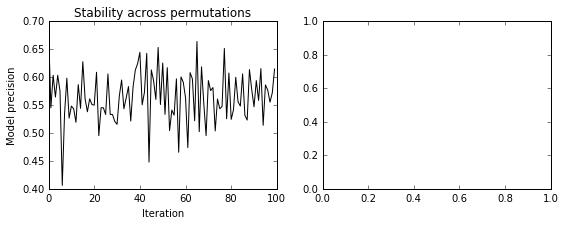

In [85]:
skf = cross_validation.StratifiedKFold( y, 10 ) 
rf = ensemble.RandomForestClassifier( class_weight='balanced_subsample' )

average_score, scores, p_value = cross_validation.permutation_test_score( rf, X, y, cv=skf, scoring='accuracy' ) 

print 'precision={0:2.2f}, p={1:2.2f}'.format( average_score, p_value ) 

plt.figure( figsize=( 9, 3 ) )
plt.subplot( 1, 2, 1 ) 
plt.plot( range( len( scores ) ), scores, color='k' )
plt.xlabel( 'Iteration' ) 
plt.ylabel( 'Model precision' ) 
plt.title( 'Stability across permutations' ) 

plt.subplot( 1, 2, 2 ) 


             precision    recall  f1-score   support

          0       0.61      0.48      0.54        23
          1       0.74      0.83      0.78        41

avg / total       0.69      0.70      0.69        64

[[11 12]
 [ 7 34]]


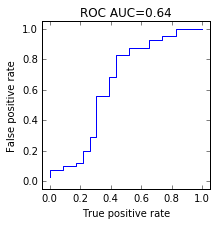

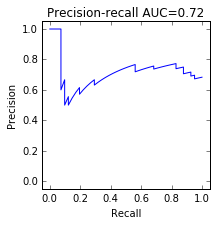

KeyError: 'rf'

In [161]:
# fit the model 
clf = GridSearchCV( pln, param_grid, cv=10 )
clf.fit( X_train, y_train )

# predict class labels in test set 
y_true, y_pred = y_test, clf.predict(X_test)

# print("Best parameters found on training set")
# print(clf.best_params_)

# print("Grid scores on training set")
# for params, mean_score, scores in clf.grid_scores_:
#     print("%0.3f (±%0.03f) for %r" % (mean_score, scores.std() * 2, params))

#print("Detailed classification report")

from sklearn.metrics import confusion_matrix

print classification_report( y_true, y_pred )
print confusion_matrix( y_true, y_pred ) 

y_desc = clf.predict_proba( X_test )
y_prob = y_desc[:,1] #[ i[j] for i, j in zip( y_desc, y_true ) ] # the probability for the given class label

# ROC curve 
tpr, fpr, __ = roc_curve( y_true, y_prob ) 
my_auc = roc_auc_score( y_true, y_prob ) 
plt.figure( figsize=( 3,3 ) ) 
plt.plot( tpr, fpr ) 
plt.xlabel( 'True positive rate' )
plt.ylabel( 'False positive rate' )
plt.title( 'ROC AUC={0:.2f}'.format( my_auc ) ) 
plt.xlim( -0.05, 1.05 ) 
plt.ylim( -0.05, 1.05 ) 
plt.show()

# Precision-recall curve 
precision, recall, __ = precision_recall_curve( y_true, y_prob ) 
my_auc = average_precision_score( y_true, y_prob ) 
plt.figure( figsize=( 3,3 ) ) 
plt.plot( recall, precision ) 
plt.xlabel( 'Recall' )
plt.ylabel( 'Precision' )
plt.title( 'Precision-recall AUC={0:.2f}'.format( my_auc ) ) 
plt.xlim( -0.05, 1.05 ) 
plt.ylim( -0.05, 1.05 ) 
plt.show()

# Feature importance 
feat_import = clf.best_estimator_.named_steps['rf'].feature_importances_
w = pandas.DataFrame( zip( df.columns[:-1], feat_import ), columns=['feature','importance'] )
w.set_index( 'feature', inplace=True ) 
w.sort_values( by='importance', ascending=False )

In [ ]:
# SVM with PCA 
param_grid = [
    { 
        'svm__kernel': [ 'rbf', 'linear' ], 
        'svm__gamma': [ 1e-3, 1e-4 ],
        'svm__C': [ .1, .3, 3, 30 ],  
        'svm__class_weight': [ 'balanced' ],
        'pca__n_components': [ 2, 5, 10 ], 
        'pca__whiten': [ True ], 
    },
]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
        
    pln = pipeline.Pipeline([
        ( 'pca', decomposition.PCA() ), 
        ( 'svm', svm.SVC() ),
    ])

    clf = GridSearchCV(pln, param_grid, cv=10, scoring='%s_weighted' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")

    print(clf.best_params_)
    print 
    print("Grid scores on development set:")
    print 
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() * 2, params))
    print 

    print("Detailed classification report:")
    print 
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print 
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    y_desc = clf.decision_function(X_test) 
    tpr, fpr, __ = roc_curve( y_true, y_desc ) 
    my_auc = roc_auc_score( y_true, y_desc ) 
    plt.figure( figsize=( 3,3 ) ) 
    plt.plot( tpr, fpr ) 
    plt.title( 'AUC={}'.format( my_auc ) ) 
    plt.show()

[1 1 0 1 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 0 0 0 0 0 0
 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1
 0 0 0 1 1 1 1 0 1 1 0 0 0 0 1 0 0]
[[33 10]
 [17 68]]
             precision    recall  f1-score   support

          0       0.66      0.77      0.71        43
          1       0.87      0.80      0.83        85

avg / total       0.80      0.79      0.79       128



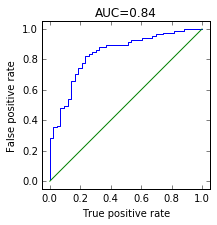

,importance
feature,
Solvation Hydrophobic,4.392592
backbone clash,3.210454
Sidechain Hbond,2.908461
torsional clash,1.714557
energy Ionisation,0.238191
Electrostatics,-0.900726
Solvation Polar,-1.103699
entropy mainchain,-1.504572
Backbone Hbond,-1.794767


In [159]:
# logistic regression 

# Set the parameters by cross-validation
param_grid = [
    { 
        'logit__class_weight': [ 'balanced', None ], 
    },
]
  
pln = pipeline.Pipeline([
    ( 'logit', LogisticRegressionCV() ),
])

clf = GridSearchCV( pln, param_grid, cv=10 )
clf.fit( X, y )
preds = clf.predict( X )
prob = clf.predict_proba( X )[:,1]
print preds

print confusion_matrix( y, preds )
print classification_report( y, preds ) 

tpr, fpr, __ = roc_curve( y, prob ) 
my_auc = roc_auc_score( y, prob ) 
plt.figure( figsize=( 3,3 ) ) 
plt.plot( tpr, fpr ) 
plt.xlabel( 'True positive rate' )
plt.ylabel( 'False positive rate' )
plt.plot( [0,1], [0,1] ) 
plt.title( 'AUC={0:.2f}'.format( my_auc ) )
plt.xlim( -0.05, 1.05 )
plt.ylim( -0.05, 1.05 )
plt.show()

feat_import = clf.best_estimator_.named_steps['logit'].coef_[0]
w = pandas.DataFrame( zip( df.columns[:-1], feat_import ), columns=['feature','importance'] )
w.set_index( 'feature', inplace=True ) 
w.sort_values( by='importance', ascending=False )

Best parameters found on training set
{'logit__class_weight': None}
Grid scores on training set
0.625 (±0.234) for {'logit__class_weight': 'balanced'}
0.656 (±0.130) for {'logit__class_weight': None}
Detailed classification report
             precision    recall  f1-score   support

          0       0.61      0.48      0.54        23
          1       0.74      0.83      0.78        41

avg / total       0.69      0.70      0.69        64



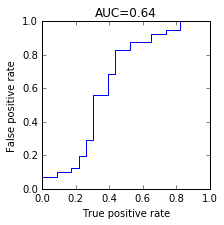

,importance
feature,
Solvation Hydrophobic,7.790288e+00
Sidechain Hbond,5.659010e+00
backbone clash,4.305304e+00
Solvation Polar,9.122644e-01
electrostatic kon,1.378353e-09
Backbone Hbond,-3.855692e-01
entropy mainchain,-2.357306e+00
Electrostatics,-2.874644e+00
energy Ionisation,-3.291004e+00


In [160]:
clf = GridSearchCV( pln, param_grid, cv=10 )
clf.fit( X_train, y_train )

print("Best parameters found on training set")
print(clf.best_params_)

print("Grid scores on training set")
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (±%0.03f) for %r" % (mean_score, scores.std() * 2, params))

print("Detailed classification report")
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))

y_desc = clf.predict_proba( X_test )
# gives a pair p(0), p(1) where p is probability and [0,1] are class labels 
# sum to 1 
y_prob = y_desc[:,1] # = [ i[j] for i, j in zip( y_desc, y_true ) ] # the probability for the given class label

tpr, fpr, __ = roc_curve( y_true, y_prob ) 
my_auc = roc_auc_score( y_true, y_prob ) 
plt.figure( figsize=( 3,3 ) ) 
plt.plot( tpr, fpr ) 
plt.xlabel( 'True positive rate' )
plt.ylabel( 'False positive rate' )
plt.title( 'AUC={0:.2f}'.format( my_auc ) ) 
plt.show()

feat_import = clf.best_estimator_.named_steps['logit'].coef_[0]
w = pandas.DataFrame( zip( df.columns[:-1], feat_import ), columns=['feature','importance'] )
w.set_index( 'feature', inplace=True ) 
w.sort_values( by='importance', ascending=False )